# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
!pip install nb_black

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

<IPython.core.display.Javascript object>

In [3]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

<IPython.core.display.Javascript object>

In [4]:
data_dir = "processed_celeba_small/celeba/"

<IPython.core.display.Javascript object>

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [5]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """Transforms to apply to the image."""

    # convert image to tensor and normalize to range [-1, 1]
    transforms_list = [
        Resize(size),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
    #     transforms_list = [Resize(size), ToTensor()]

    return Compose(transforms_list)

<IPython.core.display.Javascript object>

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [6]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from a directory.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """

    def __init__(
        self, directory: str, transform: Callable = None, extension: str = ".jpg"
    ):
        self.directory = directory
        self.transform = transform
        self.extension = extension
        self.image_files = [
            os.path.join(self.directory, f)
            for f in os.listdir(self.directory)
            if f.endswith(self.extension)
        ]

    def __len__(self) -> int:
        """returns the number of items in the dataset"""
        return len(self.image_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """load an image and apply transformation"""
        # open the image file
        image_path = self.image_files[index]
        image = Image.open(image_path)

        # apply the transformations if they exist
        if self.transform is not None:
            image = self.transform(image)

        # convert to tensor and return
        return image

<IPython.core.display.Javascript object>

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


<IPython.core.display.Javascript object>

The functions below will help you visualize images from the dataset.

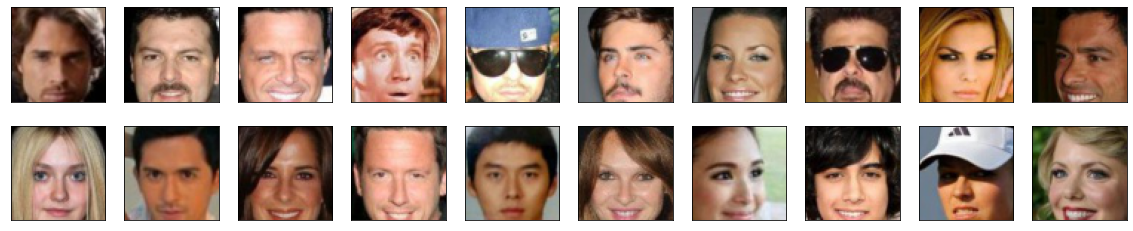

<IPython.core.display.Javascript object>

In [8]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""


def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.0) / 2.0 * 255).astype(np.uint8)


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size / 2), idx + 1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [9]:
from torch.nn import Module

<IPython.core.display.Javascript object>

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim

        self.conv1 = nn.Conv2d(
            3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv2 = nn.Conv2d(
            conv_dim, conv_dim * 2, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(conv_dim * 2)
        self.conv3 = nn.Conv2d(
            conv_dim * 2, conv_dim * 4, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(conv_dim * 4)
        self.conv4 = nn.Conv2d(
            conv_dim * 4, conv_dim * 8, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(conv_dim * 8)
        self.fc = nn.Linear(conv_dim * 8 * 4 * 4, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        # Output size should be (batch_size, conv_dim, 32, 32)

        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        # Output size should be (batch_size, conv_dim*2, 16, 16)

        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        # Output size should be (batch_size, conv_dim*4, 8, 8)

        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        # Output size should be (batch_size, conv_dim*8, 4, 4)

        x = x.view(-1, self.conv_dim * 8 * 4 * 4)
        x = self.fc(x)
        # Output size should be (batch_size, 1)

        return x

<IPython.core.display.Javascript object>

In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


<IPython.core.display.Javascript object>

### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(-1, self.latent_dim, 1, 1)
        return self.model(x)

<IPython.core.display.Javascript object>

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


<IPython.core.display.Javascript object>

## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """This function should return the optimizers of the generator and the discriminator"""
    # TODO: implement the generator and discriminator optimizers
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999  # default value

    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

<IPython.core.display.Javascript object>

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def generator_loss(fake_logits):
    """Generator loss, takes the fake scores as inputs."""
    # TODO: implement the generator loss
    return -torch.mean(fake_logits)

<IPython.core.display.Javascript object>

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [16]:
def discriminator_loss(real_logits, fake_logits):
    """Discriminator loss, takes the fake and real logits as inputs."""
    # TODO: implement the discriminator loss
    real_loss = torch.mean(real_logits)
    fake_loss = torch.mean(fake_logits)
    return fake_loss - real_loss

<IPython.core.display.Javascript object>

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [18]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """This function enforces"""
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return torch.tensor([gp])

<IPython.core.display.Javascript object>

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [19]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """One training step of the generator."""
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    latent_vector = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(latent_vector)
    fake_logits = discriminator(fake_images)
    g_loss = -torch.mean(fake_logits)
    return {"loss": g_loss}


def discriminator_step(
    batch_size: int, latent_dim: int, real_images: torch.Tensor
) -> Dict:
    """One training step of the discriminator."""
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    # generate fake images and compute fake logits
    latent_vector = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(latent_vector)
    fake_logits = discriminator(fake_images.detach())

    # compute real and fake logits
    real_logits = discriminator(real_images)

    # compute binary cross-entropy loss
    d_loss_real = F.binary_cross_entropy_with_logits(
        real_logits, torch.ones(batch_size, 1).to(device)
    )
    d_loss_fake = F.binary_cross_entropy_with_logits(
        fake_logits, torch.zeros(batch_size, 1).to(device)
    )
    d_loss = d_loss_real.mean() + d_loss_fake.mean()

    # gradient penanlty
    gp = gradient_penalty(discriminator, real_logits, fake_logits)

    return {"loss": d_loss, "gp": gp}

<IPython.core.display.Javascript object>

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [20]:
from datetime import datetime

<IPython.core.display.Javascript object>

In [21]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = "cuda"

# number of epochs to train your model
n_epochs = 6

# number of images in each batch
batch_size = 64

<IPython.core.display.Javascript object>

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=False,
)

<IPython.core.display.Javascript object>

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""


def display(fixed_latent_vector: torch.Tensor):
    """helper function to display images during training"""
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size / 2), idx + 1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

<IPython.core.display.Javascript object>

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-04-02 23:04:53 | Epoch [1/6] | Batch 0/509 | d_loss: 1.4961 | g_loss: 2.2586
2023-04-02 23:05:06 | Epoch [1/6] | Batch 50/509 | d_loss: 8.1734 | g_loss: 11.3513
2023-04-02 23:05:19 | Epoch [1/6] | Batch 100/509 | d_loss: 0.3575 | g_loss: 3.8821
2023-04-02 23:05:31 | Epoch [1/6] | Batch 150/509 | d_loss: 0.3958 | g_loss: 4.2814
2023-04-02 23:05:44 | Epoch [1/6] | Batch 200/509 | d_loss: 0.2916 | g_loss: 4.0143
2023-04-02 23:05:57 | Epoch [1/6] | Batch 250/509 | d_loss: 1.6277 | g_loss: 3.1347
2023-04-02 23:06:09 | Epoch [1/6] | Batch 300/509 | d_loss: 0.5064 | g_loss: 3.0659
2023-04-02 23:06:22 | Epoch [1/6] | Batch 350/509 | d_loss: 0.3565 | g_loss: 4.6589
2023-04-02 23:06:35 | Epoch [1/6] | Batch 400/509 | d_loss: 0.2920 | g_loss: 3.0995
2023-04-02 23:06:48 | Epoch [1/6] | Batch 450/509 | d_loss: 0.4932 | g_loss: 4.3107
2023-04-02 23:07:00 | Epoch [1/6] | Batch 500/509 | d_loss: 0.5724 | g_loss: 5.3235


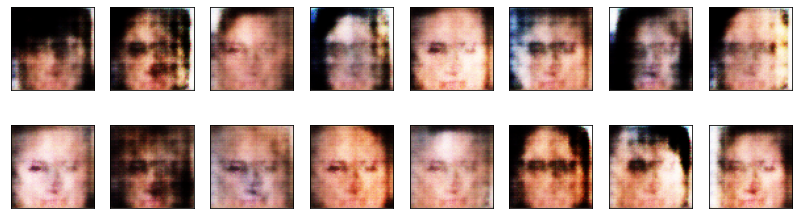

2023-04-02 23:07:04 | Epoch [2/6] | Batch 0/509 | d_loss: 0.5081 | g_loss: 3.8929
2023-04-02 23:07:16 | Epoch [2/6] | Batch 50/509 | d_loss: 0.4936 | g_loss: 4.0262
2023-04-02 23:07:29 | Epoch [2/6] | Batch 100/509 | d_loss: 0.3978 | g_loss: 3.9377
2023-04-02 23:07:42 | Epoch [2/6] | Batch 150/509 | d_loss: 0.2443 | g_loss: 3.1623
2023-04-02 23:07:54 | Epoch [2/6] | Batch 200/509 | d_loss: 0.8307 | g_loss: 6.8974
2023-04-02 23:08:07 | Epoch [2/6] | Batch 250/509 | d_loss: 0.5677 | g_loss: 4.9162
2023-04-02 23:08:20 | Epoch [2/6] | Batch 300/509 | d_loss: 2.4719 | g_loss: 5.3496
2023-04-02 23:08:32 | Epoch [2/6] | Batch 350/509 | d_loss: 1.0155 | g_loss: 6.7410
2023-04-02 23:08:45 | Epoch [2/6] | Batch 400/509 | d_loss: 0.3822 | g_loss: 4.1081
2023-04-02 23:08:58 | Epoch [2/6] | Batch 450/509 | d_loss: 0.3380 | g_loss: 4.4025
2023-04-02 23:09:10 | Epoch [2/6] | Batch 500/509 | d_loss: 0.6772 | g_loss: 5.2116


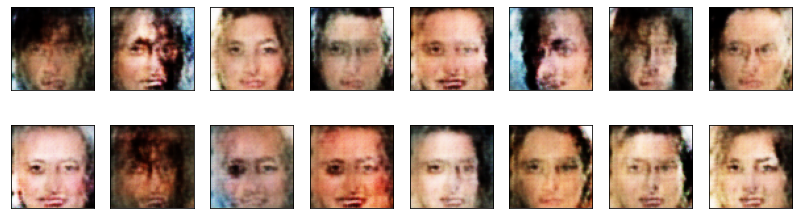

2023-04-02 23:09:14 | Epoch [3/6] | Batch 0/509 | d_loss: 1.2224 | g_loss: 8.1388
2023-04-02 23:09:27 | Epoch [3/6] | Batch 50/509 | d_loss: 0.4435 | g_loss: 4.8086
2023-04-02 23:09:39 | Epoch [3/6] | Batch 100/509 | d_loss: 1.0880 | g_loss: 4.1278
2023-04-02 23:09:52 | Epoch [3/6] | Batch 150/509 | d_loss: 0.2908 | g_loss: 3.8118
2023-04-02 23:10:05 | Epoch [3/6] | Batch 200/509 | d_loss: 0.7829 | g_loss: 4.6996
2023-04-02 23:10:17 | Epoch [3/6] | Batch 250/509 | d_loss: 0.1325 | g_loss: 2.5458
2023-04-02 23:10:30 | Epoch [3/6] | Batch 300/509 | d_loss: 1.2209 | g_loss: 3.6685
2023-04-02 23:10:43 | Epoch [3/6] | Batch 350/509 | d_loss: 0.3498 | g_loss: 2.3315
2023-04-02 23:10:55 | Epoch [3/6] | Batch 400/509 | d_loss: 0.3901 | g_loss: 3.9874
2023-04-02 23:11:08 | Epoch [3/6] | Batch 450/509 | d_loss: 0.4741 | g_loss: 4.5346
2023-04-02 23:11:21 | Epoch [3/6] | Batch 500/509 | d_loss: 0.2997 | g_loss: 1.6784


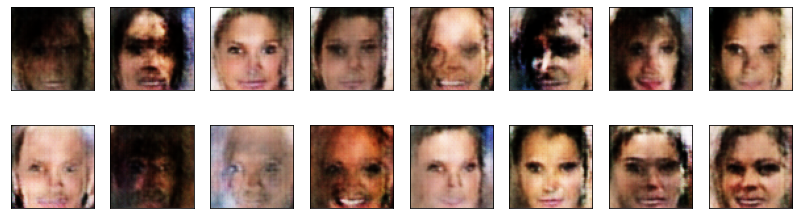

2023-04-02 23:11:24 | Epoch [4/6] | Batch 0/509 | d_loss: 0.7887 | g_loss: 5.6096
2023-04-02 23:11:37 | Epoch [4/6] | Batch 50/509 | d_loss: 0.8923 | g_loss: 1.3100
2023-04-02 23:11:49 | Epoch [4/6] | Batch 100/509 | d_loss: 0.4308 | g_loss: 3.8881
2023-04-02 23:12:02 | Epoch [4/6] | Batch 150/509 | d_loss: 0.5797 | g_loss: 1.6350
2023-04-02 23:12:15 | Epoch [4/6] | Batch 200/509 | d_loss: 0.4121 | g_loss: 4.0568
2023-04-02 23:12:27 | Epoch [4/6] | Batch 250/509 | d_loss: 0.3566 | g_loss: 3.3707
2023-04-02 23:12:40 | Epoch [4/6] | Batch 300/509 | d_loss: 0.4976 | g_loss: 1.2550
2023-04-02 23:12:53 | Epoch [4/6] | Batch 350/509 | d_loss: 0.4615 | g_loss: 3.4393
2023-04-02 23:13:05 | Epoch [4/6] | Batch 400/509 | d_loss: 0.4805 | g_loss: 5.6653
2023-04-02 23:13:18 | Epoch [4/6] | Batch 450/509 | d_loss: 0.3722 | g_loss: 3.5622
2023-04-02 23:13:31 | Epoch [4/6] | Batch 500/509 | d_loss: 0.2985 | g_loss: 3.2552


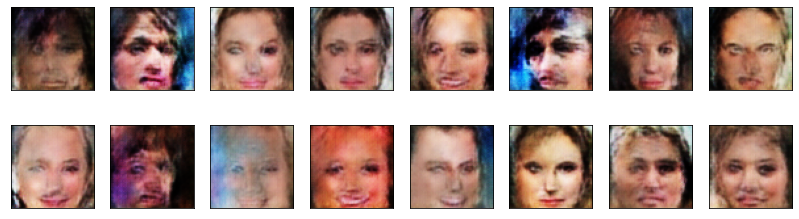

2023-04-02 23:13:34 | Epoch [5/6] | Batch 0/509 | d_loss: 0.4157 | g_loss: 6.7152
2023-04-02 23:13:47 | Epoch [5/6] | Batch 50/509 | d_loss: 6.2593 | g_loss: 4.3708
2023-04-02 23:14:00 | Epoch [5/6] | Batch 100/509 | d_loss: 0.4462 | g_loss: 4.9941
2023-04-02 23:14:12 | Epoch [5/6] | Batch 150/509 | d_loss: 2.7100 | g_loss: 2.2346
2023-04-02 23:14:25 | Epoch [5/6] | Batch 200/509 | d_loss: 1.3767 | g_loss: 1.7289
2023-04-02 23:14:38 | Epoch [5/6] | Batch 250/509 | d_loss: 3.7300 | g_loss: 4.8222
2023-04-02 23:14:50 | Epoch [5/6] | Batch 300/509 | d_loss: 0.3393 | g_loss: 2.4979
2023-04-02 23:15:03 | Epoch [5/6] | Batch 350/509 | d_loss: 0.1564 | g_loss: 2.9095
2023-04-02 23:15:16 | Epoch [5/6] | Batch 400/509 | d_loss: 0.2167 | g_loss: 4.9986
2023-04-02 23:15:29 | Epoch [5/6] | Batch 450/509 | d_loss: 0.1484 | g_loss: 3.7566
2023-04-02 23:15:41 | Epoch [5/6] | Batch 500/509 | d_loss: 0.1178 | g_loss: 3.9319


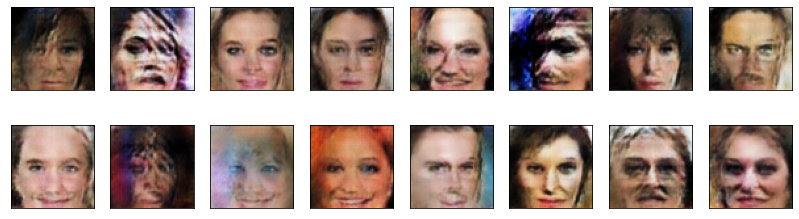

2023-04-02 23:15:44 | Epoch [6/6] | Batch 0/509 | d_loss: 0.5122 | g_loss: 5.8081
2023-04-02 23:15:57 | Epoch [6/6] | Batch 50/509 | d_loss: 0.3597 | g_loss: 2.7594
2023-04-02 23:16:10 | Epoch [6/6] | Batch 100/509 | d_loss: 0.2207 | g_loss: 3.4344
2023-04-02 23:16:23 | Epoch [6/6] | Batch 150/509 | d_loss: 0.1966 | g_loss: 4.9304
2023-04-02 23:16:35 | Epoch [6/6] | Batch 200/509 | d_loss: 0.3131 | g_loss: 2.9876
2023-04-02 23:16:48 | Epoch [6/6] | Batch 250/509 | d_loss: 0.0910 | g_loss: 3.1400
2023-04-02 23:17:01 | Epoch [6/6] | Batch 300/509 | d_loss: 0.5487 | g_loss: 2.2726
2023-04-02 23:17:13 | Epoch [6/6] | Batch 350/509 | d_loss: 0.3444 | g_loss: 3.9867
2023-04-02 23:17:26 | Epoch [6/6] | Batch 400/509 | d_loss: 0.0749 | g_loss: 4.2847
2023-04-02 23:17:39 | Epoch [6/6] | Batch 450/509 | d_loss: 0.4589 | g_loss: 2.5859
2023-04-02 23:17:51 | Epoch [6/6] | Batch 500/509 | d_loss: 0.2172 | g_loss: 3.3096


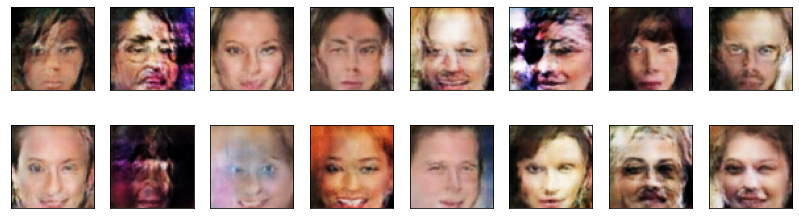

<IPython.core.display.Javascript object>

In [24]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        ####################################

        # Discriminator training
        d_optimizer.zero_grad()
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        d_loss["loss"].backward()
        d_optimizer.step()

        # Generator training
        g_optimizer.zero_grad()
        fake_images = generator(torch.randn(batch_size, latent_dim, 1, 1).to(device))
        g_loss = generator_step(batch_size, latent_dim)
        g_loss["loss"].backward()
        g_optimizer.step()

        ####################################

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss["loss"].item()
            g = g_loss["loss"].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split(".")[0]
            print(
                f"{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}"
            )

    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

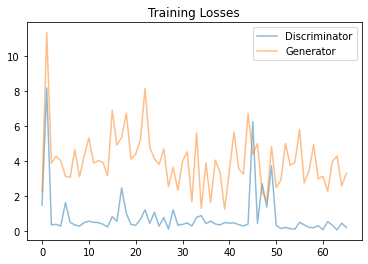

<IPython.core.display.Javascript object>

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator", alpha=0.5)
plt.plot(losses.T[1], label="Generator", alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** <br> 
* From the generated samples, it is clear that the model is struggling to generate high-quality realistic images of celebrities. The generated samples are blurry, and the facial features are not well-defined. This could be due to several factors, including the bias in the dataset, model size, optimization strategy, and loss functions.

* The dataset being biased towards white celebrities could affect the ability of the model to generate realistic images of other racial and ethnic groups. To address this, one could consider using a more diverse dataset that includes images of celebrities from different racial and ethnic backgrounds.

* Increasing the model size could also help improve the quality of the generated images. Larger models have more capacity to learn complex features in the data and could potentially generate more realistic images. However, this would come at the cost of increased computational resources required to train the model.

* Optimization strategy and the number of epochs can also have a significant impact on the quality of the generated samples. One could try using different optimizers or adjusting the learning rate to find the optimal combination for this particular task. Additionally, training the model for a longer time could also improve the quality of the generated images.

* Finally, the choice of loss function is critical in GANs as it directly affects the quality of the generated images. One could experiment with different loss functions, including the Wasserstein loss, hinge loss, or non-saturating loss, to find the optimal loss function for this task.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.